In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2125

In [5]:
class_names = dataset.classes
class_names 

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1593, 532)

In [8]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
labels[0]

tensor(4)

In [12]:
images[0].shape

torch.Size([3, 224, 224])

In [13]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.186841].


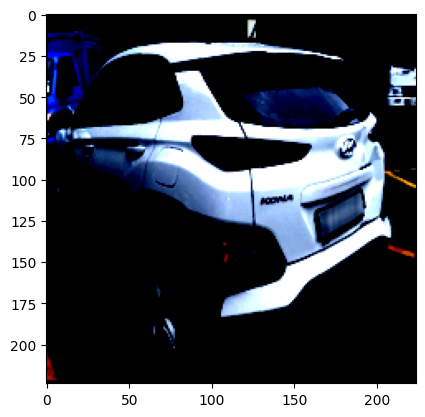

In [14]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

### Model 1: CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [16]:
images.size(0)

32

In [17]:
len(train_loader.dataset)

1593

In [18]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [22]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.70
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.61
Batch: 50, Epoch: 1, Loss: 1.73
Epoch [1/10], Avg Loss: 1.9768
*** Validation Accuracy: 43.23% ***
Batch: 10, Epoch: 2, Loss: 1.40
Batch: 20, Epoch: 2, Loss: 1.27
Batch: 30, Epoch: 2, Loss: 1.30
Batch: 40, Epoch: 2, Loss: 1.23
Batch: 50, Epoch: 2, Loss: 1.49
Epoch [2/10], Avg Loss: 1.2992
*** Validation Accuracy: 48.87% ***
Batch: 10, Epoch: 3, Loss: 0.87
Batch: 20, Epoch: 3, Loss: 1.22
Batch: 30, Epoch: 3, Loss: 1.16
Batch: 40, Epoch: 3, Loss: 1.01
Batch: 50, Epoch: 3, Loss: 0.96
Epoch [3/10], Avg Loss: 1.1161
*** Validation Accuracy: 51.13% ***
Batch: 10, Epoch: 4, Loss: 0.96
Batch: 20, Epoch: 4, Loss: 1.14
Batch: 30, Epoch: 4, Loss: 0.83
Batch: 40, Epoch: 4, Loss: 1.08
Batch: 50, Epoch: 4, Loss: 0.84
Epoch [4/10], Avg Loss: 0.9820
*** Validation Accuracy: 54.51% ***
Batch: 10, Epoch: 5, Loss: 0.90
Batch: 20, Epoch: 5, Loss: 1.06
Batch: 30, Epoch: 5, Loss: 0

### Model 2: CNN with Regularization

In [20]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [24]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 15.48
Batch: 20, Epoch: 1, Loss: 5.88
Batch: 30, Epoch: 1, Loss: 1.75
Batch: 40, Epoch: 1, Loss: 1.86
Batch: 50, Epoch: 1, Loss: 1.41
Epoch [1/10], Avg Loss: 8.4696
*** Validation Accuracy: 41.35% ***
Batch: 10, Epoch: 2, Loss: 1.78
Batch: 20, Epoch: 2, Loss: 1.51
Batch: 30, Epoch: 2, Loss: 1.32
Batch: 40, Epoch: 2, Loss: 1.27
Batch: 50, Epoch: 2, Loss: 1.45
Epoch [2/10], Avg Loss: 1.4285
*** Validation Accuracy: 50.19% ***
Batch: 10, Epoch: 3, Loss: 1.34
Batch: 20, Epoch: 3, Loss: 1.09
Batch: 30, Epoch: 3, Loss: 1.34
Batch: 40, Epoch: 3, Loss: 1.08
Batch: 50, Epoch: 3, Loss: 1.30
Epoch [3/10], Avg Loss: 1.2826
*** Validation Accuracy: 50.19% ***
Batch: 10, Epoch: 4, Loss: 0.96
Batch: 20, Epoch: 4, Loss: 0.90
Batch: 30, Epoch: 4, Loss: 1.30
Batch: 40, Epoch: 4, Loss: 1.36
Batch: 50, Epoch: 4, Loss: 1.20
Epoch [4/10], Avg Loss: 1.2043
*** Validation Accuracy: 52.63% ***
Batch: 10, Epoch: 5, Loss: 1.01
Batch: 20, Epoch: 5, Loss: 1.35
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning with EfficientNet

In [21]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [22]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [23]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.58
Batch: 20, Epoch: 1, Loss: 1.56
Batch: 30, Epoch: 1, Loss: 1.31
Batch: 40, Epoch: 1, Loss: 1.37
Batch: 50, Epoch: 1, Loss: 1.18
Epoch [1/10], Avg Loss: 1.4522
*** Validation Accuracy: 57.71% ***
Batch: 10, Epoch: 2, Loss: 1.08
Batch: 20, Epoch: 2, Loss: 1.29
Batch: 30, Epoch: 2, Loss: 1.23
Batch: 40, Epoch: 2, Loss: 1.21
Batch: 50, Epoch: 2, Loss: 0.93
Epoch [2/10], Avg Loss: 1.1263
*** Validation Accuracy: 63.91% ***
Batch: 10, Epoch: 3, Loss: 1.05
Batch: 20, Epoch: 3, Loss: 1.00
Batch: 30, Epoch: 3, Loss: 0.91
Batch: 40, Epoch: 3, Loss: 1.08
Batch: 50, Epoch: 3, Loss: 0.91
Epoch [3/10], Avg Loss: 1.0094
*** Validation Accuracy: 64.66% ***
Batch: 10, Epoch: 4, Loss: 1.03
Batch: 20, Epoch: 4, Loss: 0.88
Batch: 30, Epoch: 4, Loss: 0.96
Batch: 40, Epoch: 4, Loss: 0.95
Batch: 50, Epoch: 4, Loss: 0.89
Epoch [4/10], Avg Loss: 0.9363
*** Validation Accuracy: 66.17% ***
Batch: 10, Epoch: 5, Loss: 1.03
Batch: 20, Epoch: 5, Loss: 0.94
Batch: 30, Epoch: 5, Loss: 1

### Model 4: Transfer Learning with ResNet

In [25]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [26]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.10
Batch: 20, Epoch: 1, Loss: 0.61
Batch: 30, Epoch: 1, Loss: 0.64
Batch: 40, Epoch: 1, Loss: 0.76
Batch: 50, Epoch: 1, Loss: 0.98
Epoch [1/10], Avg Loss: 0.8905
*** Validation Accuracy: 65.04% ***
Batch: 10, Epoch: 2, Loss: 0.36
Batch: 20, Epoch: 2, Loss: 0.22
Batch: 30, Epoch: 2, Loss: 0.59
Batch: 40, Epoch: 2, Loss: 0.24
Batch: 50, Epoch: 2, Loss: 0.42
Epoch [2/10], Avg Loss: 0.4819
*** Validation Accuracy: 71.62% ***
Batch: 10, Epoch: 3, Loss: 0.53
Batch: 20, Epoch: 3, Loss: 0.29
Batch: 30, Epoch: 3, Loss: 0.17
Batch: 40, Epoch: 3, Loss: 0.26
Batch: 50, Epoch: 3, Loss: 0.64
Epoch [3/10], Avg Loss: 0.3562
*** Validation Accuracy: 76.88% ***
Batch: 10, Epoch: 4, Loss: 0.24
Batch: 20, Epoch: 4, Loss: 0.17
Batch: 30, Epoch: 4, Loss: 0.15
Batch: 40, Epoch: 4, Loss: 0.23
Batch: 50, Epoch: 4, Loss: 0.22
Epoch [4/10], Avg Loss: 0.2196
*** Validation Accuracy: 76.32% ***
Batch: 10, Epoch: 5, Loss: 0.20
Batch: 20, Epoch: 5, Loss: 0.26
Batch: 30, Epoch: 5, Loss: 0

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [27]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.15
Batch: 20, Epoch: 1, Loss: 0.83
Batch: 30, Epoch: 1, Loss: 0.93
Batch: 40, Epoch: 1, Loss: 0.69
Batch: 50, Epoch: 1, Loss: 0.58
Epoch [1/10], Avg Loss: 0.9207
*** Validation Accuracy: 57.33% ***
Batch: 10, Epoch: 2, Loss: 0.39
Batch: 20, Epoch: 2, Loss: 0.56
Batch: 30, Epoch: 2, Loss: 0.51
Batch: 40, Epoch: 2, Loss: 0.48
Batch: 50, Epoch: 2, Loss: 0.38
Epoch [2/10], Avg Loss: 0.5141
*** Validation Accuracy: 74.81% ***
Batch: 10, Epoch: 3, Loss: 0.60
Batch: 20, Epoch: 3, Loss: 0.24
Batch: 30, Epoch: 3, Loss: 0.49
Batch: 40, Epoch: 3, Loss: 0.35
Batch: 50, Epoch: 3, Loss: 0.58
Epoch [3/10], Avg Loss: 0.3821
*** Validation Accuracy: 74.06% ***
Batch: 10, Epoch: 4, Loss: 0.23
Batch: 20, Epoch: 4, Loss: 0.18
Batch: 30, Epoch: 4, Loss: 0.27
Batch: 40, Epoch: 4, Loss: 0.23
Batch: 50, Epoch: 4, Loss: 0.64
Epoch [4/10], Avg Loss: 0.2695
*** Validation Accuracy: 74.44% ***
Batch: 10, Epoch: 5, Loss: 0.15
Batch: 20, Epoch: 5, Loss: 0.15
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [28]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       124
           1       0.73      0.65      0.69        57
           2       0.85      0.92      0.88       124
           3       0.81      0.67      0.73        69
           4       0.67      0.84      0.74        85
           5       0.90      0.73      0.80        73

    accuracy                           0.81       532
   macro avg       0.80      0.78      0.79       532
weighted avg       0.81      0.81      0.81       532



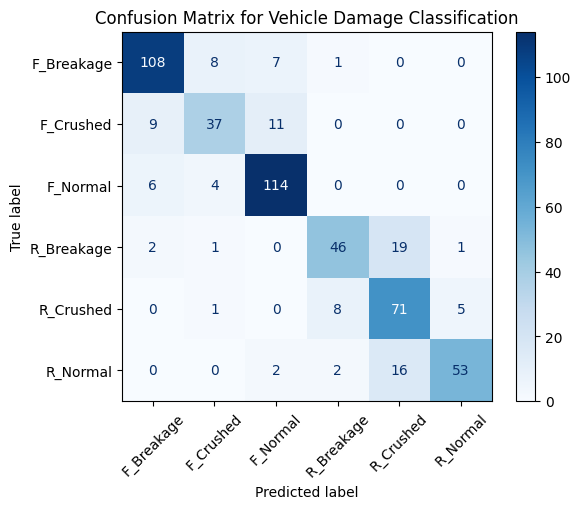

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [30]:
torch.save(model.state_dict(), 'saved_model.pth')